## ProjF3 - Baseline Model

Use this document as a template to provide the evaluation of your baseline model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

This notebook augments EfficientNetB0 with additional layers to incorporate the tabular data. The general goal was to use a CNN on this project - So we decided why not start with one that already is trained on images as a baseline
A multi-target regression approach is used (as opposed to multiple models)

In [25]:
import os
import sys
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import matplotlib.pyplot as plt 
import seaborn as sns 
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

### Load data, append image paths, define target columns

In [2]:
train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')

sd_columns = [col for col in train.columns if col.endswith('_sd')]
train = train.drop(columns=sd_columns)

train_image_folder = '/kaggle/input/planttraits2024/train_images'
train['image_path'] = train['id'].apply(lambda x: os.path.join(train_image_folder, f"{x}.jpeg"))

test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test_image_folder = '/kaggle/input/planttraits2024/test_images'
test['image_path'] = test['id'].apply(lambda x: os.path.join(test_image_folder, f"{x}.jpeg"))

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

#limit train data for quick test
#train = train.head(10000)

### Image pre-processing and dataset functions

In [3]:
# Define image augmentation operations
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_crop(img, size=[224, 224, 3])  # Random cropping
    return img

# Process image with augmentation
def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = augment_image(img)  # Apply augmentation
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular_data, targets):
    img = process_image(file_path)
    return (img, tabular_data), targets

## Plot train data

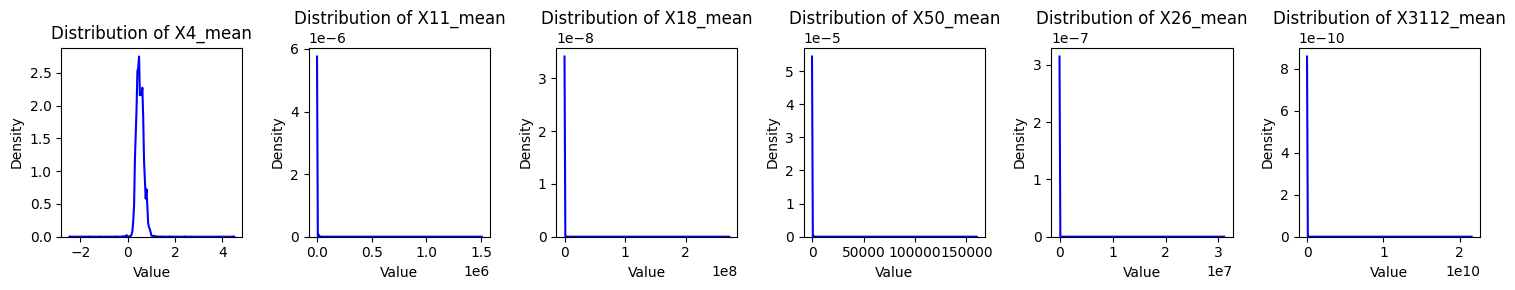

In [4]:
def plot_data(df):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(mean_columns) // n_cols + (len(mean_columns) % n_cols > 0)

    for i, col in enumerate(mean_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    
plot_data(train)

## Drop bad training data

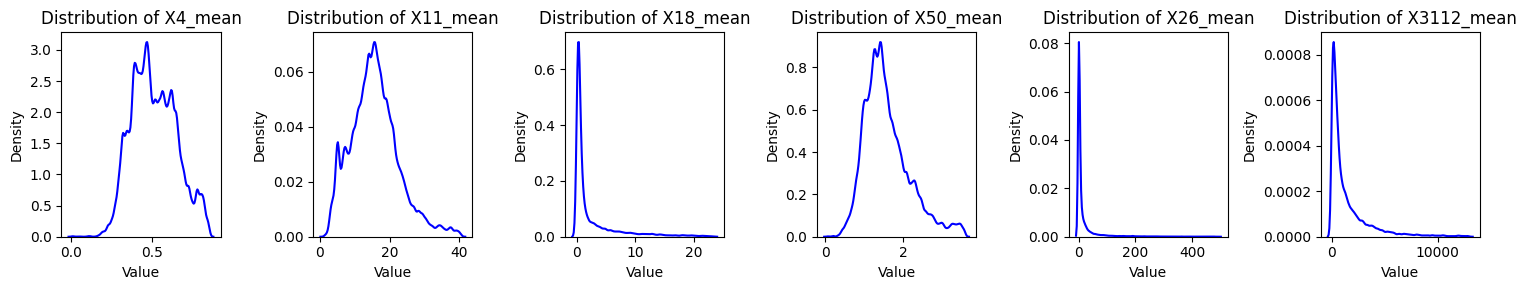

In [5]:
for column in mean_columns:
    upper_quantile = train[column].quantile(0.98)  
    train = train[(train[column] < upper_quantile)]
    train = train[(train[column] > 0)]    
plot_data(train)

## Normalize target values

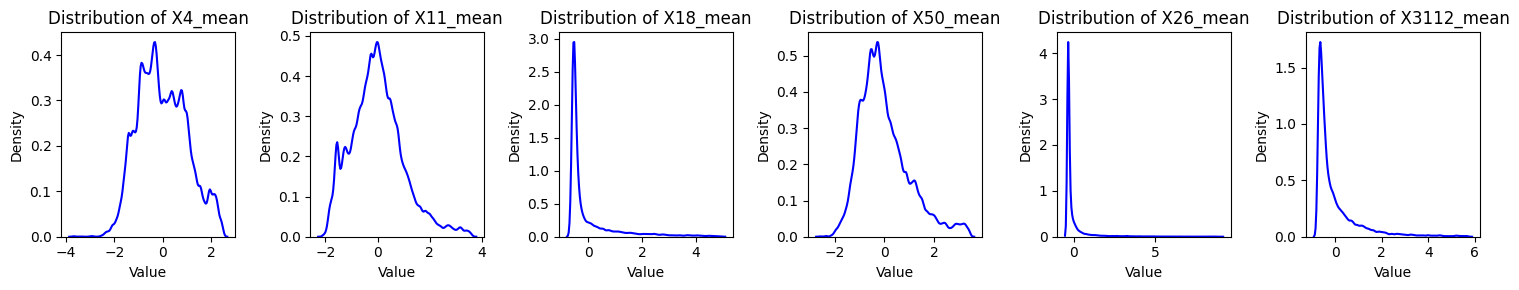

In [6]:
original_means = {}
original_stds = {}

for column in mean_columns:
    # Calculate the mean and standard deviation for each column
    original_means[column] = train[column].mean()
    original_stds[column] = train[column].std()
    
    # Apply the scaling: (value - mean) / std
    # This standardizes each column to have a mean of 0 and std of 1
    train[column] = (train[column] - original_means[column]) / original_stds[column]
    
plot_data(train)

## Normalize tabular inputs

In [7]:
x = train.drop(columns=['id', 'image_path'] + mean_columns)

for column in x.columns:
    min_val = x[column].min()
    max_val = x[column].max()
    x[column] = (x[column] - min_val) / (max_val - min_val)    

## Create train validation and test sets

In [10]:
y = train[mean_columns]
x_paths = train['image_path']

train_tabular, test_tabular, train_targets, test_targets = train_test_split(
    x, y, test_size=0.25, random_state=42)

train_paths, test_paths = train_test_split(
    x_paths, test_size=0.25, random_state=42)

test_tabular, val_tabular, test_targets, val_targets = train_test_split(
    test_tabular, test_targets,test_size=0.6, random_state=42)

test_paths, val_paths = train_test_split(
    test_paths, test_size=0.6, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_tabular.to_numpy(), train_targets.to_numpy()))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_tabular.to_numpy(), val_targets.to_numpy()))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_tabular.to_numpy(), test_targets.to_numpy()))

# Apply the processing function
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## 2. Prepare your Baseline Model

Here you can have your code to either train (e.g., if you are building it from scratch) or load (e.g., in the case that you are loading a pre-trained model) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

## Load pre-trained model EfficientNetB0 and augment with tabular data layers / multi-target regression

In [11]:
# Image model pathway
image_input = Input(shape=(224, 224, 3))
effnet_layer = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input, pooling='avg')
effnet_layer.trainable = False  # Freeze EfficientNetB0 to reuse pre-trained features

# Tabular model pathway
tabular_input = Input(shape=(train_tabular.shape[1],))
tabular_dense = Dense(512, activation='relu')(tabular_input)
tabular_dense = Dropout(0.5)(tabular_dense)  # Add dropout for regularization

# Concatenate both pathways
concat = Concatenate()([effnet_layer.output, tabular_dense])
concat_dense = Dense(256, activation='relu')(concat)
concat_dense = Dropout(0.5)(concat_dense)  # Continue to use dropout for regularization

# Output layer for 6 targets
output = Dense(len(mean_columns), activation='linear', dtype = tf.float64)(concat_dense)  # Use linear activation for regression

model = Model(inputs=[image_input, tabular_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'R2Score'])

#model.summary()
model


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<Functional name=functional_1, built=True>

## Model Training

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
   3/1149 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - R2Score: -0.6069 - loss: 1.3338 - mae: 0.8412    

I0000 00:00:1712547031.817892      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712547031.880008      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - R2Score: 0.0861 - loss: 0.9087 - mae: 0.6635

W0000 00:00:1712547186.746500      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 235s 165ms/step - R2Score: 0.0862 - loss: 0.9087 - mae: 0.6635 - val_R2Score: 0.2095 - val_loss: 0.7823 - val_mae: 0.6049
Epoch 2/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - R2Score: 0.1721 - loss: 0.8243 - mae: 0.6209 - val_R2Score: 0.2225 - val_loss: 0.7692 - val_mae: 0.5988
Epoch 3/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - R2Score: 0.1903 - loss: 0.8061 - mae: 0.6128 - val_R2Score: 0.2283 - val_loss: 0.7635 - val_mae: 0.6020
Epoch 4/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 73s 64ms/step - R2Score: 0.1999 - loss: 0.7967 - mae: 0.6072 - val_R2Score: 0.2259 - val_loss: 0.7659 - val_mae: 0.5920
Epoch 5/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 74s 65ms/step - R2Score: 0.2033 - loss: 0.7931 - mae: 0.6042 - val_R2Score: 0.2370 - val_loss: 0.7549 - val_mae: 0.5914
Epoch 6/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 73s 63ms/step - R2Score: 0.2115 - loss: 0.7851 - mae: 0.6007 - val_R2Score: 0.2378 - val_loss: 0.7541 - val_mae: 0.5893
Epoch 7/20
1149/1149 ━━━━━━━━━━━━━━━━

## Save model weights

In [13]:
model.save_weights("model.weights.h5")

## Create dataset for test data

In [14]:
test_tabular_np = test_tabular.to_numpy()

# Create a TensorFlow dataset for the image paths and map them through the preprocessing function
test_images_ds = tf.data.Dataset.from_tensor_slices(test_paths)\
    .map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Create a TensorFlow dataset for the tabular data
test_tabular_ds = tf.data.Dataset.from_tensor_slices(test_tabular_np)

# Zip the two datasets together
test_ds = tf.data.Dataset.zip((test_images_ds, test_tabular_ds))

# Prepare the dataset for prediction by ensuring the structure matches the model's expectations
test_ds_for_prediction = test_ds.map(lambda image, tabular: ((image, tabular),), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the dataset
test_ds_batched = test_ds_for_prediction.batch(32)

# Use the model to predict on the batched dataset
predictions = model.predict(test_ds_batched)

predictions_df = pd.DataFrame(predictions, columns=mean_columns)
test = pd.concat([test.reset_index(drop=True), predictions_df], axis=1)

  3/154 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step 

W0000 00:00:1712548646.585835      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


154/154 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step


## 3. Baseline Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

## Performance / Metrics for Train data 

In [2]:
print("The R2 Score for training data is 0.2506" )
print("The Mean square error  0.7462") 
print("The mean absolute error is mae: 0.5852" )
## Values taken from Model training cell

The R2 Score for training data is 0.2506
The Mean square error  0.7462
The mean absolute error is mae: 0.5852


## Predictions for test data 

In [15]:
predictions_df.head()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,-0.618660,0.038871,-0.431012,-0.191022,-0.259924,-0.308009
1,0.305864,-0.357785,-0.015052,0.171607,-0.184332,-0.259726
2,0.192361,-0.212591,-0.013273,0.075316,-0.023447,0.013914
3,-0.372631,0.072371,-0.459006,0.038237,-0.275581,-0.355676
4,-0.009688,-0.176211,0.743095,0.218130,0.537194,0.246511


In [16]:
predictions_df.shape

(4901, 6)

## Performance / Metrics for Test data 

In [24]:
print("The mean squared error is : ", mean_squared_error(test_targets, predictions))
print("The mean absolute error is : ", mean_absolute_error(test_targets, predictions))
print("The R2 score is: ",  r2_score(test_targets, predictions))

The mean squared error is :  0.7414115545799866
The mean absolute error is :  0.5856322429709387
The R2 score is:  0.2629566579776725


In [50]:
for col in mean_columns:
    print("Mean Squared error for", col)
    print(mean_squared_error(test_targets[col], predictions_df[col]))
    print("Mean Absolute error for", col)
    print(mean_absolute_error(test_targets[col], predictions_df[col]))
    print("R2 score for", col)
    print(r2_score(test_targets[col], predictions_df[col]))
    print("")

Mean Squared error for X4_mean
0.7597467245772178
Mean Absolute error for X4_mean
0.7086008437578393
R2 score for X4_mean
0.2622311625982535

Mean Squared error for X11_mean
0.7511850909821954
Mean Absolute error for X11_mean
0.6675498449532338
R2 score for X11_mean
0.24622893417068425

Mean Squared error for X18_mean
0.5594709532333952
Mean Absolute error for X18_mean
0.4566083366579465
R2 score for X18_mean
0.4291350068752845

Mean Squared error for X50_mean
0.8570918914320178
Mean Absolute error for X50_mean
0.7008502077140202
R2 score for X50_mean
0.1441398964685865

Mean Squared error for X26_mean
0.845941000054679
Mean Absolute error for X26_mean
0.43833078584861807
R2 score for X26_mean
0.20494480718285868

Mean Squared error for X3112_mean
0.6750336672004131
Mean Absolute error for X3112_mean
0.5418534388939751
R2 score for X3112_mean
0.29106014057036855



## Graphs for Predictions vs Actual for each target variable

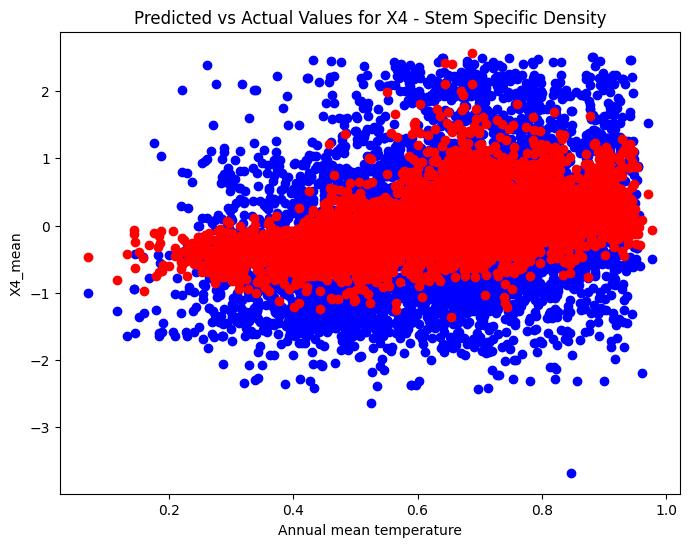

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X4_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X4_mean'],color='red')
plt.title('Predicted vs Actual Values for X4 - Stem Specific Density')
plt.xlabel('Annual mean temperature')
plt.ylabel('X4_mean')
plt.show()

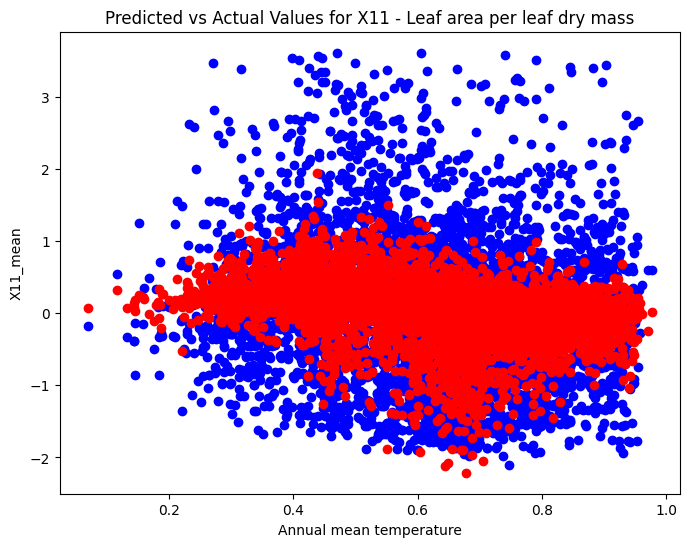

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X11_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X11_mean'],color='red')
plt.title('Predicted vs Actual Values for X11 - Leaf area per leaf dry mass')
plt.xlabel('Annual mean temperature')
plt.ylabel('X11_mean')
plt.show()

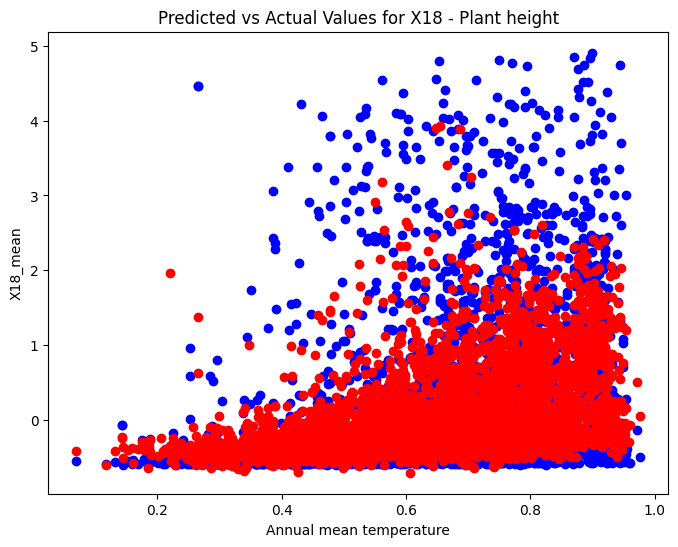

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X18_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X18_mean'],color='red')
plt.title('Predicted vs Actual Values for X18 - Plant height')
plt.xlabel('Annual mean temperature')
plt.ylabel('X18_mean')
plt.show()

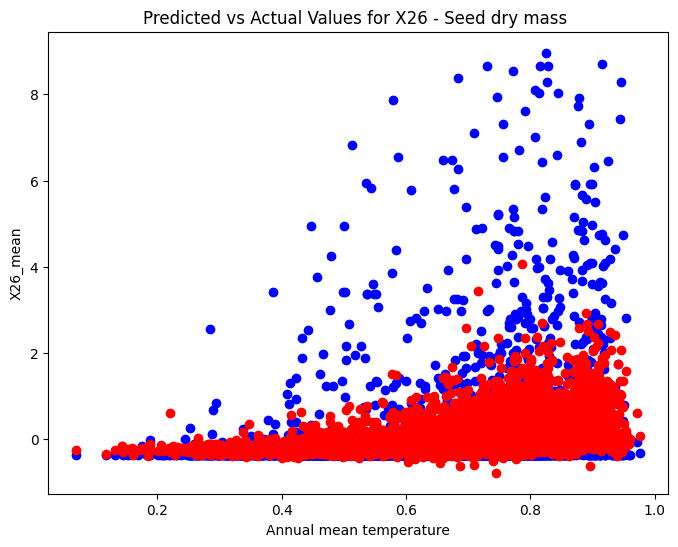

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X26_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X26_mean'],color='red')
plt.title('Predicted vs Actual Values for X26 - Seed dry mass ')
plt.xlabel('Annual mean temperature')
plt.ylabel('X26_mean')
plt.show()

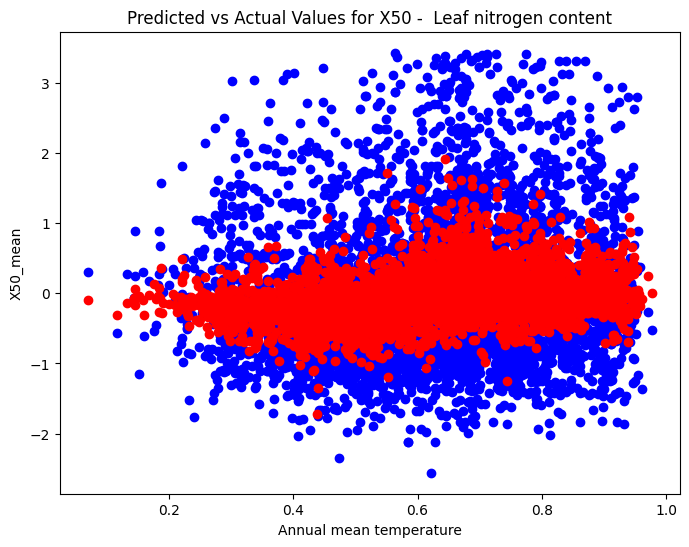

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X50_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X50_mean'],color='red')
plt.title('Predicted vs Actual Values for X50 -  Leaf nitrogen content')
plt.xlabel('Annual mean temperature')
plt.ylabel('X50_mean')
plt.show()

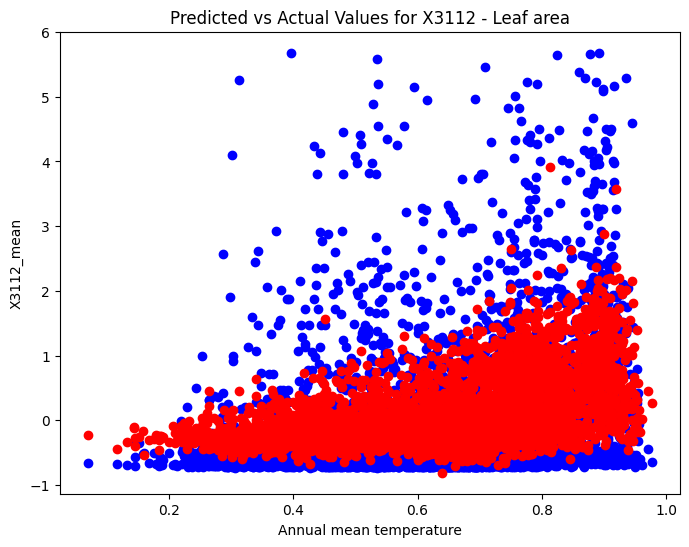

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], test_targets['X3112_mean'], color='blue')
plt.scatter( test_tabular['WORLDCLIM_BIO1_annual_mean_temperature'], predictions_df['X3112_mean'],color='red')
plt.title('Predicted vs Actual Values for X3112 - Leaf area')
plt.xlabel('Annual mean temperature')
plt.ylabel('X3112_mean')
plt.show()